## Table of Contents
* [Load S3 image](#Load-S3-image)
* [Show ratio1 band](#Show-ratio1-band)
* [Load the model and make predictions on the S3 image](#Load-the-model-and-make-predictions-on-the-S3-image)
* [Make standard deviation preds with GPR model](#Make-standard-deviation-preds-with-GPR-model)
* [Save preds to `envi`](#Save-preds-to-envi)

In [1]:
from ml import cdom_processing
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.externals import joblib
from ml import data_load

## Load S3 image 

In [2]:
s3image_path = "/media/disk/databases/C2X/S3Images/subset_0_of_S3A_OL_2_WFR____20170708T084007_20170708T084307_20170708T104714_0179_019_335_1979_MAR_O_NR_002.data"
img = cdom_processing.load_S3_image(image_path=s3image_path)
img.shape

(2369, 3329, 18)

## Load and show water mask

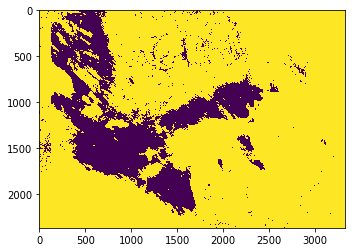

In [3]:
mascara = cdom_processing.load_mask(s3image_path)
mascara = (mascara==1)
plt.imshow(mascara)

## Show ratio1 band
[Table of Contents](#Table-of-Contents)

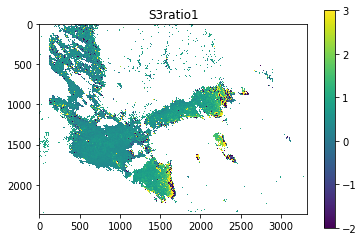

In [4]:
ratio = np.ma.masked_array(img[:,:,16],mascara)
plt.imshow(ratio,vmin=-2,vmax=3)
plt.colorbar()
_ = plt.title(cdom_processing.BAND_NAMES_S3_RATIOS[16])

## Load the model and make predictions on the S3 image
[Table of Contents](#Table-of-Contents)

In [5]:
# Load the model
name_model = "GPR"
bands_name = "S3bands"

def load_model(name_model,bands_name):
    file_model = os.path.join(data_load.PATH_TO_MODELS_C2X,
                              "CDOM_"+name_model+'_'+bands_name+'.pkl')
    return joblib.load(file_model)

regressor_sklearn = load_model(name_model,bands_name)
regressor_sklearn

Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('gaussianprocessregressor', GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) + WhiteKernel(noise_level=1e-05),
             n_restarts_optimizer=4, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None))])

In [6]:
# Select the bands of the image to predict
image_predict = cdom_processing.image_to_predict_S3(img,data_load.bands_try_C2X[bands_name])
image_predict.shape

(2369, 3329, 15)

In [7]:
# Load training data to add the mean and compute the min,max range of the predicted variable
_, _, skdata_y_train, _ = data_load.load_C2X()
skdata_y_train = skdata_y_train["a_440_cdom"].values

mean_y_train = np.mean(skdata_y_train)
max_cdom = np.max(skdata_y_train)
predictions = cdom_processing.predict_image(image_predict,
                                            mascara,
                                            regressor_sklearn,
                                            y_range=(0,max_cdom),
                                            y_mean=mean_y_train,step=300)
predictions.shape

(2369, 3329)

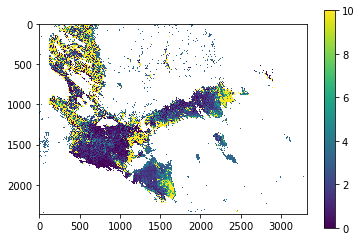

In [8]:
plt.imshow(predictions,vmin=0,vmax=10)
plt.colorbar()

## Make standard deviation preds with GPR model
[Table of Contents](#Table-of-Contents)

In [9]:
if name_model == "GPR":
    min_max_scaler_ = regressor_sklearn.steps[0][1]
    gpr_model_ = regressor_sklearn.steps[1][1]
    predict_function = lambda data: gpr_model_.predict(min_max_scaler_.transform(data),
                                                       return_std=True)[1]
    predictions_std = cdom_processing.predict_image(image_predict,
                                                    mascara,
                                                    predict_function=predict_function,
                                                    y_range=(0,99999),
                                                    y_mean=0,step=300)
    predictions_std.shape


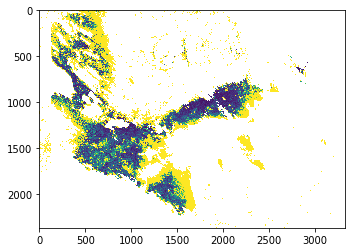

In [19]:
if name_model == "GPR":
    plt.imshow(predictions_std,vmin=0,vmax=50)


## Save preds to `envi`
[Table of Contents](#Table-of-Contents)

In [11]:
folder_save = "."
cdom_processing.write_envi(predictions_std, os.path.join(folder_save,
                                                         name_model+'_'+bands_name+'_CDOM_C2X_std.hdr'))
                           

Saving /home/gonmagar/git/mlregocean/GPR_S3bands_CDOM_C2X_std.img
